# Train a propensity score (PS) model
One option to resolve missingness for AFA is to use inverse probability weighting. 
This notebook trains PS models and saves the computed propensity scores for the dataset. 

### Define paths 

In [1]:
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1'

# name for ps_model 
ps_model_name  = 'ps_lr'

# specifications
data_dir       = "../../../data/ts/" + dataset_name + "/" + miss_scenario + "/" 
data_file          = data_dir + dataset_name + '_' + miss_scenario + '_static.csv.gz' 
temporal_data_file = data_dir + dataset_name + '_' + miss_scenario + '_ts_eav.csv.gz' 
superfeature_mapping_file = data_dir + 'superfeatures.csv'
problem_file   = data_dir + 'problem/' + 'problem.yaml'
afa_problem_files = {
        'action_file'          : data_dir + 'afa_problem/' + 'acquisition_actions.csv', 
        'prediction_cost_file' : data_dir + 'afa_problem/' + 'prediction_cost.csv'
                }
folds_file = data_dir + 'folds/' + 'fold_list.hkl'

# new (where to save the model) 
ps_model_dir = data_dir + 'ps_models' + '/' + ps_model_name + '/'

# define files needed to load missingness model
ps_model_gt_name = 'ps_model_' + miss_scenario + '_gt'  # to compare with 
ps_model_names = [ps_model_gt_name] 
miss_model_files = {
    'm_graph_adj_file' : data_dir + '/' + 'm_graphs/' + 'm_graph_adjacencies.csv',
    'ps_values_dirs' : [data_dir + 'ps_models/' + ps_model_name + '/' + 'ps_values/' for ps_model_name in ps_model_names]
    }

# reporting
explanation_file = ps_model_dir +  'reports/' + 'model_report' 

### Define model specifications

In [2]:
ps_model_params = {
    'name' : ps_model_name, 
    'base_model_params' : {  'base_model_type': 'stationary_constant',
                              'units': 1 ,
                              'layers': 1,
                              'learning_rate': 0.01,
                              'epochs': 100,
                              'checkpoint_dir': ps_model_dir + 'checkpoints/'
                          }
    }

### Imports 

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os

# navigate to afa directory 
sys.path.insert(0, os.path.abspath('../../afa'))

## Load dataset with missingness 
At first, we want to load the dataset 

Includes loading: 
- superfeature mapping
- problem
- afa_problem 
- missingness_model

In [4]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-02-05 21:19:27.264240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 21:19:27.412997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 21:19:27.413016: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 21:19:28.166185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
data_loader = DataLoader_ts( data_file                  = data_file,
                             temporal_data_file         = temporal_data_file,
                             superfeature_mapping_file  = superfeature_mapping_file,
                             problem_file               = problem_file,
                             afa_problem_files          = afa_problem_files, 
                             miss_model_files           = miss_model_files,
                             folds_file = folds_file)
dataset = data_loader.load() 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 810.19it/s]


## Define propensity score model

In [6]:
from afa.data_modelling.missingness.propensity_scores.propensity_score_model_ts import PropensityScoreModel_ts

ps_model = PropensityScoreModel_ts(  name                         = ps_model_params['name'], 
                                     m_graph                      = dataset.miss_model.m_graph, 
                                     feature_name                 = dataset.feature_name,
                                     target_superfeature_names    = dataset.afa_problem.target_superfeature_names,
                                     model_params                 = ps_model_params ) 

Change base_model to stationary_constant
Change base_model to stationary_constant


## Fit propensity score model

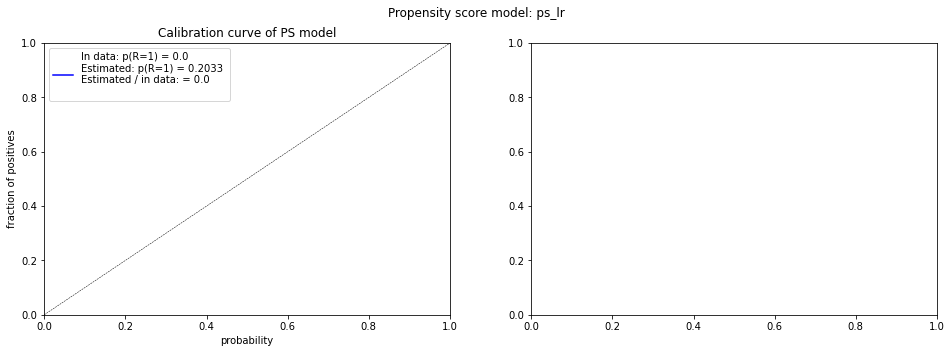

In [7]:
ps_model.fit(dataset, fold = 0, train_split = 'train', valid_split = 'val', fit_again = True)

## Compute the propensity score for the dataset

We add the computed propensity scores to the dataset.

In [8]:
# compute ps values
ps_values, ps_values_1 = ps_model.predict(dataset)

In [9]:
# add ps_values
dataset.miss_model.add_ps_values( ps_model_name , 
                                  ps_values = ps_values, 
                                  ps_values_1 = ps_values_1 )

In [10]:
dataset.miss_model.ps_models['ps_model_MCAR_1_gt']['ps_values'].shape

(100, 10)

## Compare all propensity scores in dataset

We might have computed multiple different propensity scores (e.g. also the ground truth propensity score) using different models and want to compare their predictions now. 

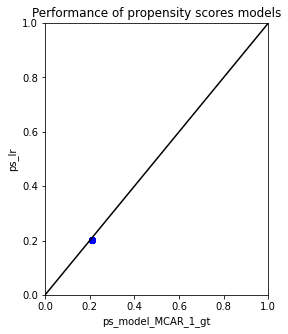

In [11]:
dataset.miss_model.plot_ps_comparison(values_1 = True)

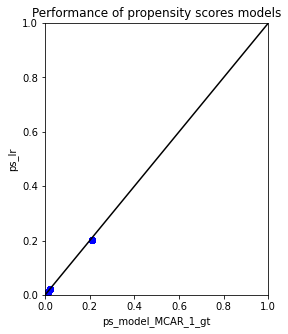

In [12]:
dataset.miss_model.plot_ps_comparison(values_1 = False)

## Reporting: summarize the propensity score model and its training performance
Store information in reports folder in latex / markdown format.

In [13]:
ps_model.explain(file=  explanation_file + '.md', format = 'markdown')
#ps_model.explain(file=  explanation_file + '.tex', format = 'latex')